In [1]:
%pwd

'e:\\Github Projects\\Retinal_Blood_Vessels_Segmentation\\notebooks'

In [2]:
import sys
sys.path.append("E:\\Github Projects\\Retinal_Blood_Vessels_Segmentation")

In [32]:
import os

import cv2
import numpy as np

from patchify import patchify, unpatchify

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    LeakyReLU,
    MaxPool2D
)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from scripts.prepare_data import convert_images_to_rgb

In [4]:
def make_patches(dir: str, shape: tuple) -> tuple:
    img_patch_shape = (*shape, 3)
    mask_patch_shape = shape

    X = [cv2.imread(f"{dir}/img/{img_name}") for img_name in os.listdir(f'{dir}/img/')]
    X = convert_images_to_rgb(X)

    y = [cv2.imread(f"{dir}/mask/{img_name}", cv2.IMREAD_GRAYSCALE) for img_name in os.listdir(f'{dir}/mask/')]

    X_patchified = [patchify(img, img_patch_shape, step=img_patch_shape[0]) for img in X]
    y_patchified = [patchify(mask, mask_patch_shape, step=mask_patch_shape[0]) for mask in y]

    img_patches, mask_patches = [], []

    for patchified_image in X_patchified:
        for i in range(patchified_image.shape[0]):
            for j in range(patchified_image.shape[1]):
                img_patches.append(patchified_image[i, j, :, :][0])

    for patchified_mask in y_patchified:
        for i in range(patchified_image.shape[0]):
            for j in range(patchified_image.shape[1]):
                mask_patches.append(patchified_mask[i, j, :, :])
    

    return np.array(img_patches), np.array(mask_patches)

In [5]:
train_dir = "../cropped_images/train"
test_dir = "../cropped_images/test"

img_patch_shape = (64, 64, 3)
mask_patch_shape = (64, 64)

X_train, y_train = make_patches(train_dir, shape=(64, 64))
X_test, y_test = make_patches(test_dir, shape=(64, 64))

train_images_number = X_train.shape[0]
test_images_number = X_test.shape[0]
batch_size = 16

y_train = y_train.reshape(train_images_number, *mask_patch_shape, 1)
y_test = y_test.reshape(test_images_number, *mask_patch_shape, 1)

seed = 42

train_img_datagen_params = dict(rotation_range=90,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                            fill_mode='reflect',
                            rescale=1./255
)

train_mask_datagen_params = dict(rotation_range=90,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                            fill_mode='reflect',
                            preprocessing_function=lambda x: np.where(x>0, 1, 0).astype(x.dtype)
)

train_datagen_images = ImageDataGenerator(**train_img_datagen_params)
train_datagen_masks = ImageDataGenerator(**train_mask_datagen_params)

train_images = train_datagen_images.flow(X_train, batch_size=batch_size, seed=seed)
train_masks = train_datagen_masks.flow(y_train, batch_size=batch_size, seed=seed)
# albo train_datagen_images.fit(X_train, augment=True, seed=seed) i wtedy flow

# train_images = train_datagen_images.flow_from_directory(directory=f"{train_dir}",
#                                                         target_size=(512, 512),
#                                                         batch_size=2,
#                                                         class_mode=None,
#                                                         classes=["img"],
#                                                         seed=seed)
# train_masks = train_datagen_masks.flow_from_directory(directory=f"{train_dir}",
#                                                       target_size=(512, 512),
#                                                       batch_size=2,
#                                                       class_mode=None,
#                                                       color_mode="grayscale",
#                                                       classes=["mask"],
#                                                       seed=seed)


test_datagen_params = dict(rescale=1./255)

test_datagen_images = ImageDataGenerator(**test_datagen_params)
test_datagen_masks = ImageDataGenerator(**test_datagen_params)

test_images = test_datagen_images.flow(X_test, batch_size=batch_size, seed=seed)
test_masks = test_datagen_masks.flow(y_test, batch_size=batch_size, seed=seed)

# test_images = test_datagen_images.flow_from_directory(directory=f"{test_dir}",
#                                                       target_size=(512, 512),
#                                                       class_mode=None,
#                                                       batch_size=2,
#                                                       classes=["img"],
#                                                       seed=seed)
# test_masks = test_datagen_masks.flow_from_directory(directory=f"{test_dir}",
#                                                     target_size=(512, 512),
#                                                     class_mode=None,
#                                                     batch_size=2,
#                                                     color_mode="grayscale",
#                                                     classes=["mask"],
#                                                     seed=seed)

train_set = zip(train_images, train_masks)
test_set = zip(test_images, test_masks)

In [6]:
import tensorflow as tf

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
# def build_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     kernel_initializer =  'he_uniform'
#     s = inputs

#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
#     c1 = BatchNormalization()(c1)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
#     c1 = BatchNormalization()(c1)
#     p1 = MaxPool2D((2, 2))(c1)
    
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
#     c2 = BatchNormalization()(c2)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
#     c2 = BatchNormalization()(c2)
#     p2 = MaxPool2D((2, 2))(c2)
     
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
#     c3 = BatchNormalization()(c3)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
#     c3 = BatchNormalization()(c3)
#     p3 = MaxPool2D((2, 2))(c3)
     
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
#     c4 = BatchNormalization()(c4)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
#     c4 = BatchNormalization()(c4)
#     p4 = MaxPool2D(pool_size=(2, 2))(c4)
     
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
#     c5 = BatchNormalization()(c5)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
#     c5 = BatchNormalization()(c5)
    
    
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = Concatenate([u6, c4])
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
#     c6 = BatchNormalization()(c6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
#     c6 = BatchNormalization()(c6)
     
#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = Concatenate([u7, c3])
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
#     c7 = BatchNormalization()(c7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
#     c7 = BatchNormalization()(c7)
     
#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = Concatenate([u8, c2])
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
#     c8 = BatchNormalization()(c8)
#     c8 = Dropout(0.1)(c8)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
#     c8 = BatchNormalization()(c8)
     
#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = Concatenate([u9, c1], axis=3)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
#     c9 = BatchNormalization()(c9)
#     c9 = Dropout(0.1)(c9)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
#     c9 = BatchNormalization()(c9)
     
#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # maybe use softmax
     
#     model = Model(inputs=[inputs], outputs=[outputs])
#     model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])  # maybe categorical_crossentropy
#     # model.compile(optimizer=Adam(lr = 1e-3), loss=dice_loss, metrics=['accuracy', dice_coef])
#     # model.summary()
    
#     return model

In [7]:
kernel_initializer =  'he_uniform'

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [8]:
model = build_unet((64, 64, 3))
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy', dice_coef])

In [9]:
callbacks = [
    ModelCheckpoint(filepath="../models/model-{epoch:02d}-{val_loss:.2f}.hdf5",
                    monitor="val_loss",
                    save_best_only=True),
    EarlyStopping(monitor="val_loss",
                  patience=10,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss",
                      factor=0.1,
                      patience=5,
                      verbose=1,
                      min_lr=1e-6)
]

# model.compile(loss=dice_loss, optimizer=Adam(learning_rate=1e-4), metrics=[dice_coef, iou, Recall(), Precision()])

In [10]:
model.fit(train_set,
          validation_data=test_set,
          epochs=100,
          steps_per_epoch=train_images_number//batch_size,
          validation_steps=test_images_number//batch_size,
          callbacks=callbacks)

Epoch 1/100
295/295 [==============================] - 56s 170ms/step - loss: 0.4861 - accuracy: 0.8779 - dice_coef: 0.5139 - val_loss: 0.7513 - val_accuracy: 0.9324 - val_dice_coef: 0.2487
Epoch 2/100
295/295 [==============================] - 51s 167ms/step - loss: 0.3465 - accuracy: 0.9388 - dice_coef: 0.6534 - val_loss: 0.4880 - val_accuracy: 0.9313 - val_dice_coef: 0.5120
Epoch 3/100
295/295 [==============================] - 49s 168ms/step - loss: 0.3273 - accuracy: 0.9435 - dice_coef: 0.6728 - val_loss: 0.5147 - val_accuracy: 0.9135 - val_dice_coef: 0.4853
Epoch 4/100
295/295 [==============================] - 50s 168ms/step - loss: 0.3081 - accuracy: 0.9460 - dice_coef: 0.6918 - val_loss: 0.3516 - val_accuracy: 0.9582 - val_dice_coef: 0.6484
Epoch 5/100
295/295 [==============================] - 50s 171ms/step - loss: 0.3096 - accuracy: 0.9467 - dice_coef: 0.6906 - val_loss: 0.3409 - val_accuracy: 0.9589 - val_dice_coef: 0.6591
Epoch 6/100
295/295 [=============================

In [64]:
def make_prediction(img: str) -> np.ndarray:
    img_patch_shape = (64, 64, 3)
    mask_patch_shape = (64, 64)

    sample_test_img_patchified = patchify(img, patch_size=img_patch_shape, step=img_patch_shape[0])

    number_of_patches = sample_test_img_patchified.shape[0] * sample_test_img_patchified.shape[1]

    sample_test_img_patches = sample_test_img_patchified.reshape(number_of_patches, *img_patch_shape)
    sample_test_img_patches = np.expand_dims(sample_test_img_patches, axis=0)

    y_pred = np.array([model.predict(sample_patch) for sample_patch in sample_test_img_patches]).reshape(sample_test_img_patchified.shape[0], sample_test_img_patchified.shape[0], *mask_patch_shape)

    return unpatchify(y_pred, (960, 960))

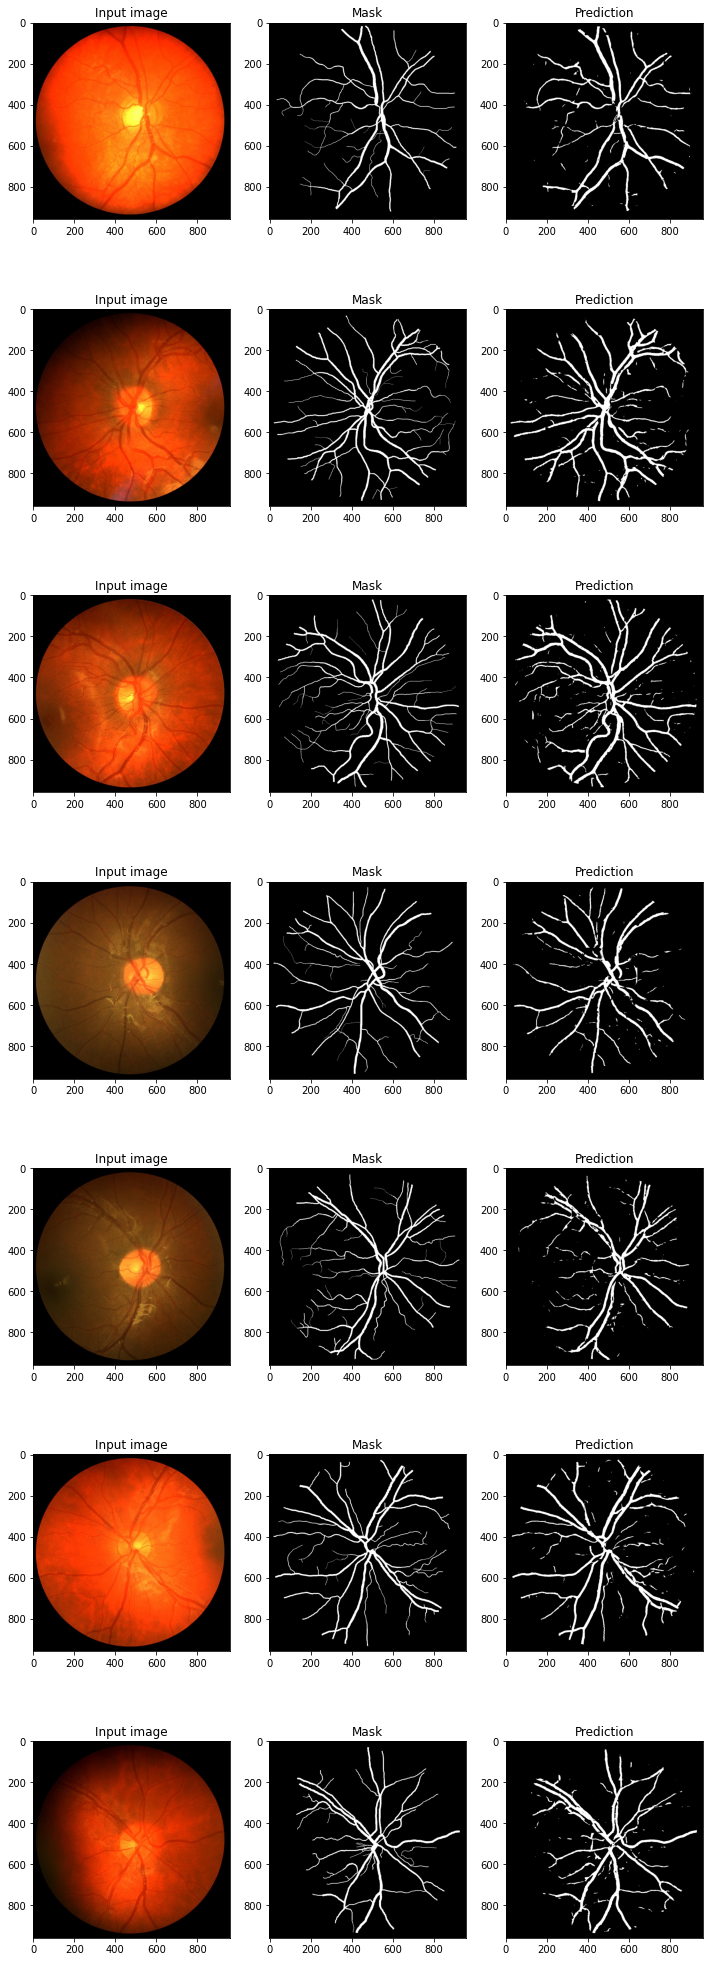

In [65]:
import matplotlib.pyplot as plt

test_images_names = os.listdir(f'{test_dir}/img')
test_masks_names = os.listdir(f'{test_dir}/mask')

test_images = [cv2.imread(f'{test_dir}/img/{img_name}') for img_name in test_images_names]
test_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255 for img in test_images]

test_masks = [cv2.imread(f'{test_dir}/mask/{mask_name}', cv2.IMREAD_GRAYSCALE) for mask_name in test_masks_names]

test_preds = [make_prediction(test_img) for test_img in test_images]

plt.figure(figsize=(12, 36))

for i, (img, pred, mask) in enumerate(zip(test_images, test_preds, test_masks)):
    plt.subplot(7, 3, i*3 + 1)
    plt.imshow(img)
    plt.title('Input image')

    plt.subplot(7, 3, i*3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.subplot(7, 3, i*3 + 3)
    plt.imshow(pred, cmap='gray')
    plt.title('Prediction')

plt.show()